## This is sample Python Code working with the National Water Model
This notebook demonstrates a few different ways that you can use Python to access the NWM data. A few options are shown commented out, such as the differences between grabbing short range or medium range or different reach segments. You can experiment with the different settings by adjusting these comments to ses some variations. Also note that the location where we are grabbing the NWM data only stores forecasts fore a few weeks so at some point the dates will no longer be available and you will need to update them to be more current for the code to work. You will also want to download the sample sub-setted files from the same site where you obtained this notebook for the later blocks to work. 

In [1]:
import requests
import numpy
from owslib.waterml.wml11 import WaterML_1_1 as wml
import datetime as dt
import netCDF4
import matplotlib.pyplot as plt
import os

# Use the API from the NWM Viewer app to get the WaterML text
def get_nwm_forecast(config, comid, startdate, enddate, forecasttime):
    url = 'https://appsdev.hydroshare.org/apps/nwm-forecasts/api/GetWaterML/?config=' + config + '&geom=channel_rt&variable=streamflow&COMID=' + comid + '&lon=-87.5658033081755&lat=33.2279708144365&startDate='+startdate+'&endDate='+enddate+'&time='+forecasttime+'&lag=t00z'
    res = requests.get(url).content
    return res

## Query the NWM for a forecast on a stream from the NHD Plus and parse the raw WaterML
This block of code demonstrates how to construct a call to the get_nwm_forecast code by setting up the comid, configuration, startdate, enddate, and forecasttime. By default it is set up to get the short range forecast for Two Mile Creek as it empties into the Black Warrior River in Tuscaloosa on June 5, 2017 for the 18:00 hour. Code is commented out that would let you change to the Provo River at Utah Lake or Otter Creek in Middlebury, Vermont. Code is also commented out that shows how to specify the medium range forecast at time 00:00.

In this example you will get the raw waterml code and be shown how to parse through it to extract the date-streamflow pairs for plotting.

In [2]:
# setup some variables to process the date and time series values
# we are going to download two forecasts and compare
dateraw = []
date1 = []
value1 = []
date2 = []
value2 = []
# This is where you can change the input and rerun to get a different stream, forecast configuration, and time
# You can identify different COMID's from the NHDPlus or use the NWM Forecast Viewer App at https://apps.hydroshare.org/apps/
# two mile creek in Tuscaloosa, Alabama 18228725
comid = '18228725'
# Provo River at Utah Lake 10376192
#comid ='10376192'
# Otter Creek Outlet at gage
#comid = '22221755'
# The different configurations are short_range, medium_range, or analysis_assim
config = 'short_range'
startdate = '2017-06-05'
enddate = '2017-06-05'
forecasttime = '18'
#config = 'medium_range'
#startdate = '2017-06-05'
#enddate = '2017-06-05'
#forecasttime = '00'
# start time is 00 to 23 for short_range and should be 00 for both if doing medium_range. analysis_assim ignores hours
# call the function we set up above to get the first forecast
watermlstring = str(get_nwm_forecast(config, comid, startdate, enddate, forecasttime))
#print (watermlstring)
waterml = watermlstring.split('dateTimeUTC="')
#print ('')
#print (waterml[0])
#print ('')
#print (waterml[1])
waterml.pop(0)
# process the first forecast
for e in waterml:
    parser = e.split('"  methodCode="1"  sourceCode="1"  qualityControlLevelCode="1" >')
    dateraw.append(parser[0])
    value1.append(parser[1].split('<')[0])

for e in dateraw:
    date1.append(dt.datetime.strptime(e, "%Y-%m-%dT%H:%M:%S"))


## Get the next forecast
This block of code demonstrates how to get the next forecast so that two consecutive forecasts can be compared. For the short range the next forecast is the next hour (19) while for the medium range the next forecast is the next day. However, in the medium range there are now forecasts every six hours so you could have used the same date and changed the time to 06, 12, or 18.

In [3]:
# reset dateraw and change the date to get a second forecast    
dateraw = []
# for short range
startdate = '2017-06-05'
enddate = '2017-06-05'
forecasttime = '19'
# for mediumrange
#startdate = '2017-06-06'
#enddate = '2017-06-06'
#forecasttime = '00'
# call the function
watermlstring = str(get_nwm_forecast(config, comid, startdate, enddate, forecasttime))
waterml = watermlstring.split('dateTimeUTC="')
waterml.pop(0)
# process the second forecast
for e in waterml:
    parser = e.split('"  methodCode="1"  sourceCode="1"  qualityControlLevelCode="1" >')
    dateraw.append(parser[0])
    value2.append(parser[1].split('<')[0])

for e in dateraw:
    date2.append(dt.datetime.strptime(e, "%Y-%m-%dT%H:%M:%S"))

## Plot the two consecutive forecasts and their difference
Note that code that processes the medium range assumes the two forecasts are for consecutive days not the next ensemble. The medium range forecasts have 3-hour time steps or 8 time-streamflow pairs per day and hence the offset in the code. If you were to grab the next ensemble the offset would only be 2 time steps instead of 8.

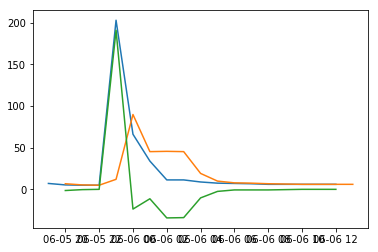

In [4]:
# we want to create a third plot as the difference of the first two over the time periods they match
date3 = []
value3 = []

if config == 'short_range':
    for i,item in enumerate(value1):
        if i < (len(value1)-1):
            value3.append(float(value1[i+1])-float(value2[i]))
    for i in range(17):
        date3.append(date2[i])
elif config == 'medium_range':    
    for i,item in enumerate(value1):
        if i < (len(value1)-8):
            value3.append(float(value1[i+8])-float(value2[i]))
    for i in range(72):
        date3.append(date2[i])
# plot the two forecast time series and their difference
fig= plt.plot(date1, value1)
fig= plt.plot(date2, value2)
fig= plt.plot(date3, value3)
plt.show()


## Process the same forecast using WaterML
In the first set of calls we parsed the raw WaterML code. However the owswlib has libraries for parsing the waterml standard which is more efficient. This next block shows how to use that library to get the same date-streamflow pairs.

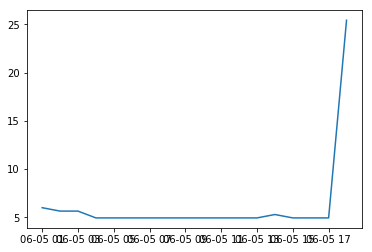

In [5]:
# this code illustrates using waterml functions from owslib to get a forecast similar to what we have been doing above
date = []
value = []
url = 'https://appsdev.hydroshare.org/apps/nwm-forecasts/api/GetWaterML/?config=' + config + '&geom=channel_rt&variable=streamflow&COMID=' + comid + '&lon=-87.5658033081755&lat=33.2279708144365&startDate=2017-06-05&endDate=2017-06-05&time=00&lag=t00z'
response = requests.get(url)
owslibstring = response.text.encode('utf-8')
parse_wml = wml(owslibstring).response
variable = parse_wml.get_series_by_variable(var_name='Flow Forecast')
value_list = variable[0].values[0]
value_pairs = value_list.get_date_values()
for e in value_pairs:
    date.append(e[0])
    value.append(e[1])
fig= plt.plot(date, value)
plt.show()

## Processing NWM data subsetted from the NWM Forecast Viewer
You can subset NWM output using a polygon shapefile to create a single netCDF file with all time steps for all the river reaches (COMIDs) within the polygon. This code defines some functions used for processing subsetted NWM output from the NWM Forecast Viewer App on apps.hydroshare.org.

In [6]:
def list_comids(netcdf_path, length_only=False):
    '''
    List all comids values or total number in a NWM netcdf
    :param netcdf_path: full path to NWM netcdf file
    :param length_only: if True, return total number of contained comids; Default: False
    :return: all contained comid values in a list, or total number of comids if length_only=True
    '''

    with netCDF4.Dataset(netcdf_path, mode='r', format="NETCDF4_CLASSIC") as in_nc:
        if length_only:
            return len(in_nc.variables["feature_id"])
        else:
            return list(in_nc.variables["feature_id"][:])


def list_hydrologic_variables(netcdf_path):
    '''
    List all name of all cotained hydrologic variables
    :param netcdf_path: netcdf path
    :return: list of variable names
    '''
    hydrologic_var_list = []
    with netCDF4.Dataset(netcdf_path, mode='r', format="NETCDF4_CLASSIC") as in_nc:
#        for name, var_obj in in_nc.variables:
        for e in in_nc.variables:
            hydrologic_var_list.append(e)
#             if len(var_obj.dimensions) > 1 and var_obj.dimensions[0] == "time":
#                 hydrologic_var_list.append(name)
    return hydrologic_var_list


def get_variable_values(netcdf_path, var_name, comid, datetime_format=None, paired=False):
    '''
    Retrieve timeseries for a variable of a given comid
    :param netcdf_path: netcdf file path
    :param var_name: variable name
    :param comid: comid
    :param datetime_format: datetime string format in output; If set to None, return datetime object
                            IF set to "%Y%m%d-%H:%M:%S", return YYYYMMDD-HH:MM:SS;  Default: None
    :param paired: If True, return one list: [[time1, value1], [time2, value2]...]
                   If False, return two lists: [time1, time2], [value1, value2...]
                   Default: False
    :return: see paired
    '''
    t_series = []
    time_list = []
    value_list = []
    with netCDF4.Dataset(netcdf_path, mode='r', format="NETCDF4_CLASSIC") as in_nc:

        var_time = in_nc.variables["time"]
        if datetime_format is None:
            time_list = [netCDF4.num2date(t, var_time.units) for t in var_time[:]]
        else:
            time_list = [netCDF4.num2date(t, var_time.units).strftime(datetime_format) for t in var_time[:]]

            
        if comid is None or str(comid).lower() == "grid":
            value_list = list(in_nc.variables[var_name][:])
        else:
            # find index for input comid:
            comid_index = -1
            for idx in range(len(in_nc.variables["feature_id"][:])):
                if in_nc.variables["feature_id"][idx] == int(comid):
                    comid_index = idx
                    break
            value_list = list(in_nc.variables[var_name][:, comid_index])
    
    if paired:
        for index in range(len(time_list)):
            t_series.append([time_list[index], value_list[index]])
        return t_series
    else:
        return time_list, value_list

## Streamflow forecasts from subsetted data
Here we process from disk the subsetted and downloaded NWM streamflow forecasts. In the sample data provided we have downloaded the short range, medium range, and analysis and assimilation data for Two Mile Creek in Tuscaloosa on June 4, 2017. The default opens up the medium range forecast but you can adjust the comments to see the other two. Also note that the block of code prints the available variables so you can see what is there besides streamflow which could then be processed instead.

['time', 'streamflow', 'nudge', 'q_lateral', 'velocity', 'feature_id', 'reference_time']


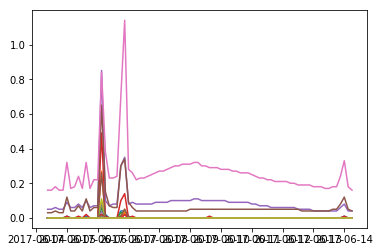

In [7]:
# AA streamflow
#netcdf_path = os.path.join(".","nwm.20170604", "analysis_assim", "nwm.tALLz.analysis_assim.channel_rt.tm00.conus.nc")
# SR streamflow
#netcdf_path = os.path.join(".","nwm.20170604", "short_range", "nwm.t02z.short_range.channel_rt.fALL.conus.nc")
# MR streamflow
netcdf_path = os.path.join(".","nwm.20170604", "medium_range", "nwm.t06z.medium_range.channel_rt.fALL.conus.nc")

# Forcings

# this block of code is used to get forecasts off of streams
# list comids
all_comids = list_comids(netcdf_path)
#print (list_comids(netcdf_path))
# list variables
print (list_hydrologic_variables(netcdf_path))
# retrieve timeseries for a variable of a comid

for strm_id in all_comids:
    date_list,  value_list = get_variable_values(netcdf_path, "streamflow", str(strm_id))
    fig = plt.plot(date_list, value_list)
   
plt.show()

## Gridded (Land/Forcing) NWM subsetted data
Here we process the gridded output from NWM data. Code is also shown commented out for how the forcing data can be processed. This generates a 2-D array of values for different time steps. The default parameter for the output is the soil saturation whereas for the forcing it is rainfall rate (commented out but should be changed if you uncomment the code or path to the forcings). The list of variables is printed so that you can see what others are available.

['time', 'FSA', 'FIRA', 'GRDFLX', 'HFX', 'LH', 'UGDRNOFF', 'ACCECAN', 'ACCEDIR', 'ACCETRAN', 'TRAD', 'SNLIQ', 'SOIL_T', 'SOIL_M', 'SNOWH', 'SNEQV', 'ISNOW', 'FSNO', 'ACSNOM', 'ACCET', 'CANWAT', 'SOILICE', 'SOILSAT_TOP', 'SNOWT_AVG', 'x', 'y', 'ProjectionCoordinateSystem', 'reference_time']


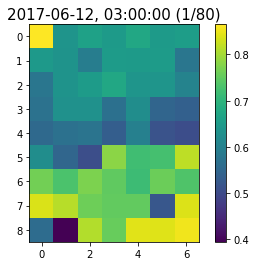

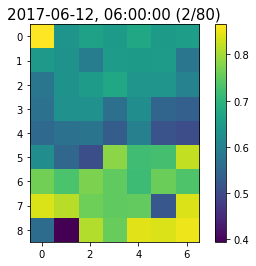

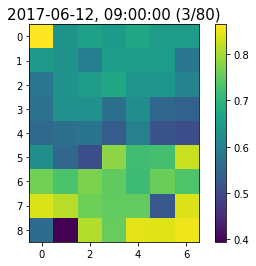

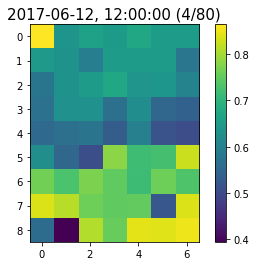

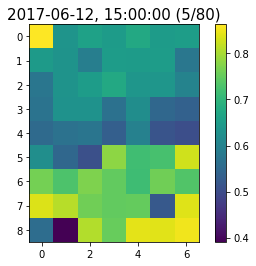

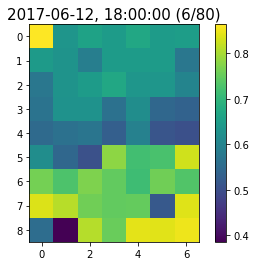

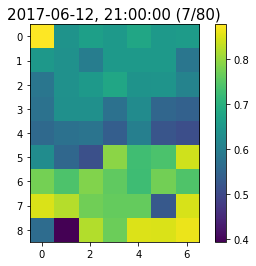

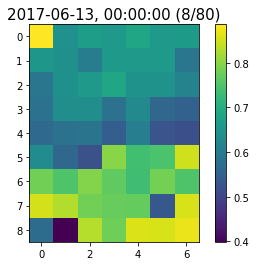

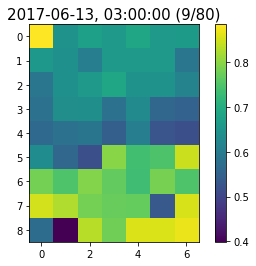

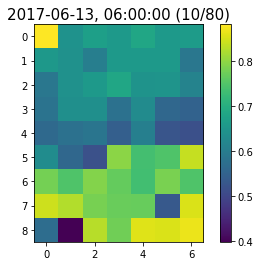

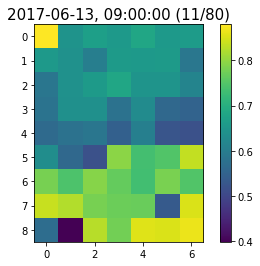

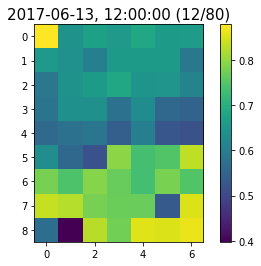

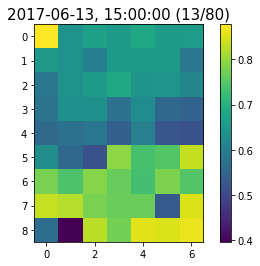

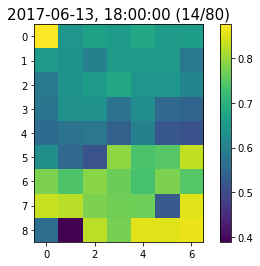

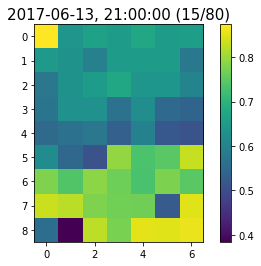

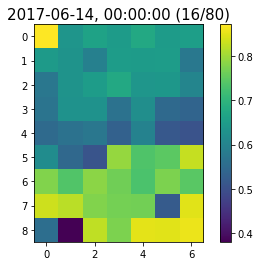

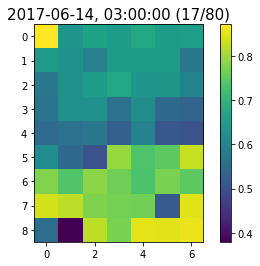

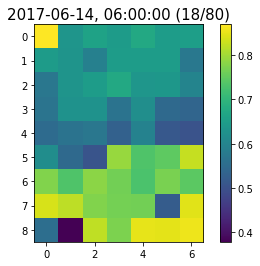

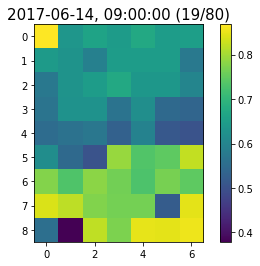

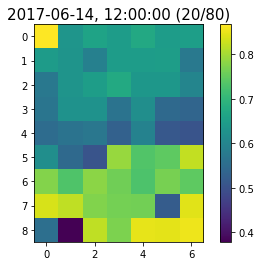

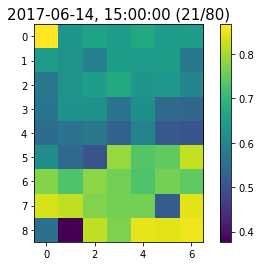

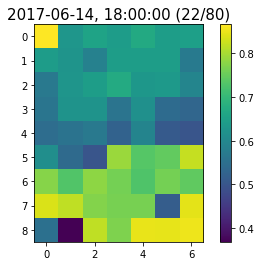

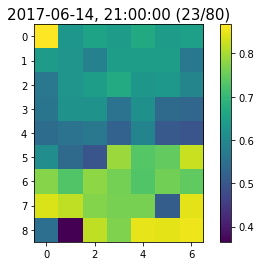

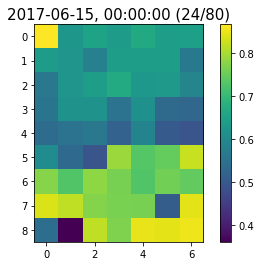

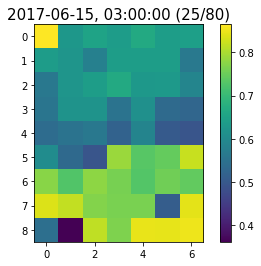

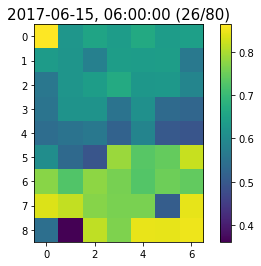

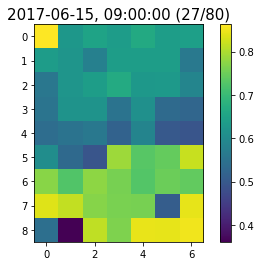

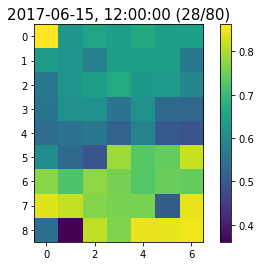

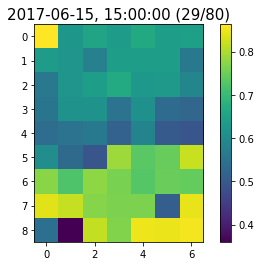

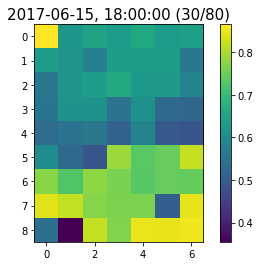

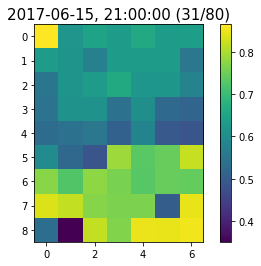

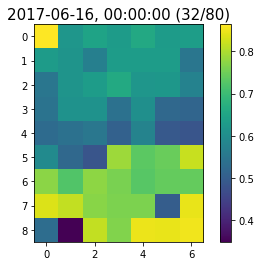

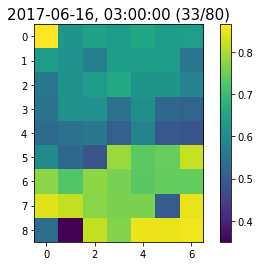

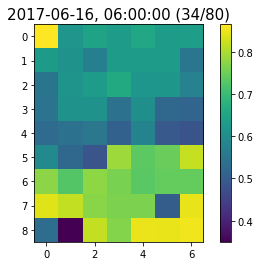

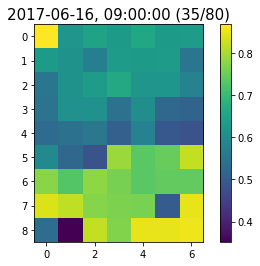

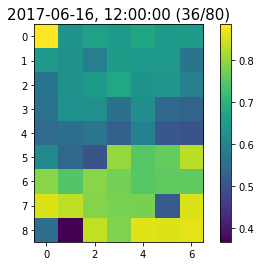

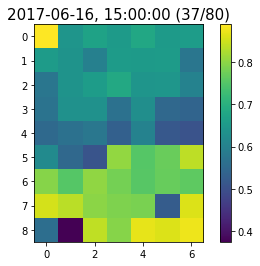

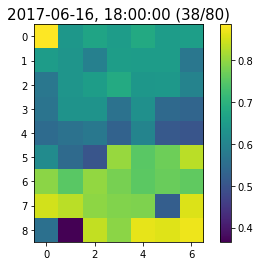

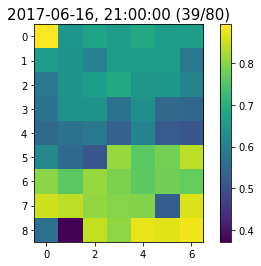

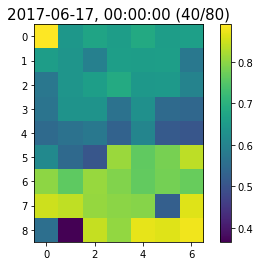

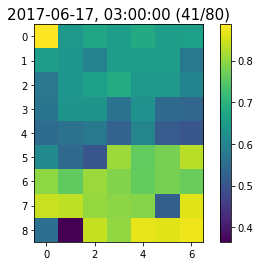

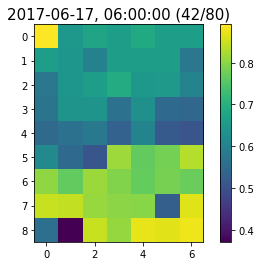

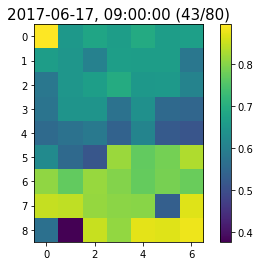

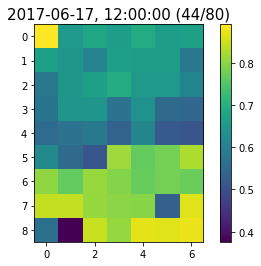

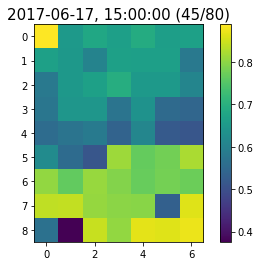

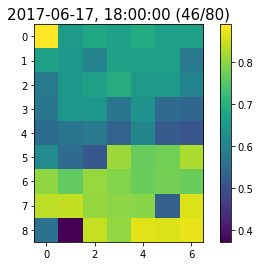

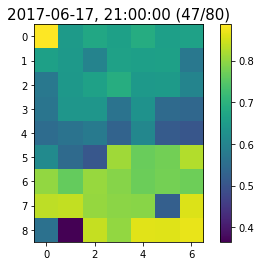

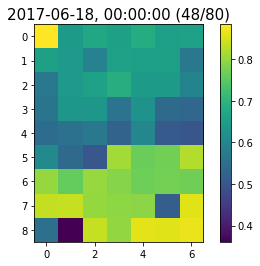

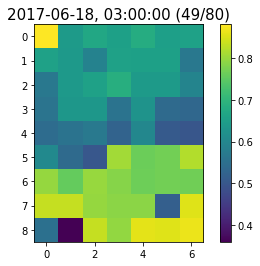

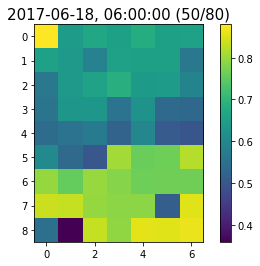

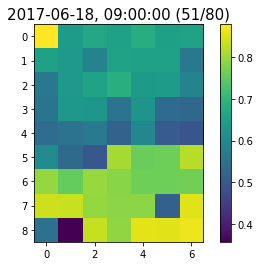

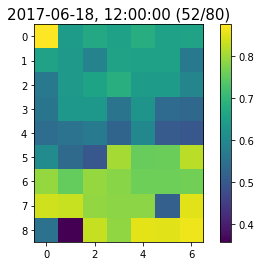

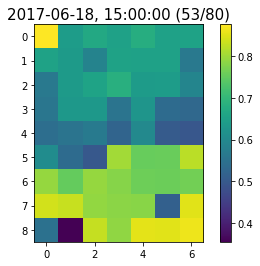

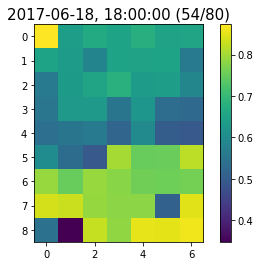

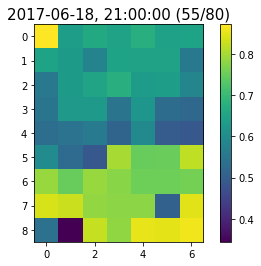

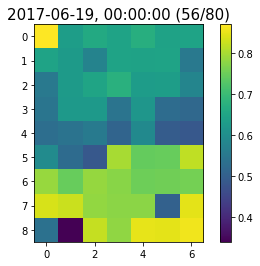

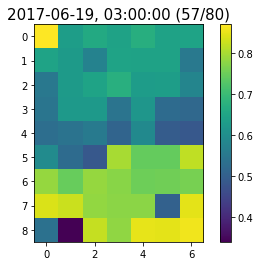

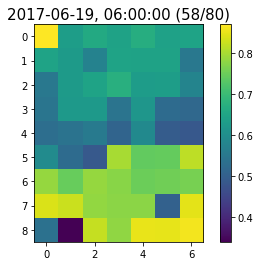

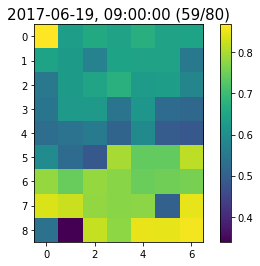

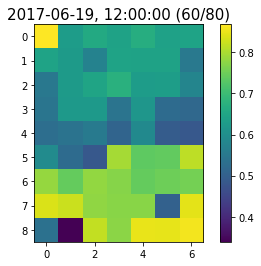

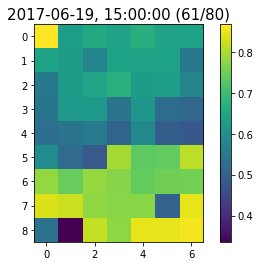

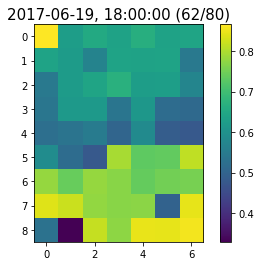

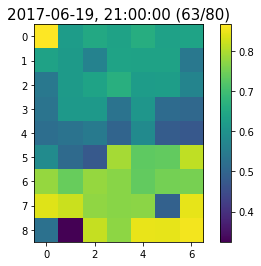

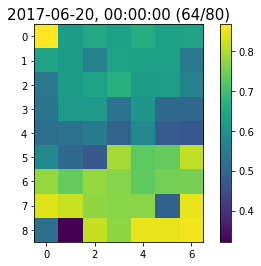

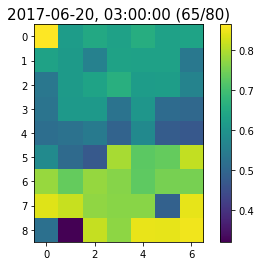

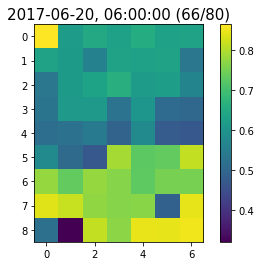

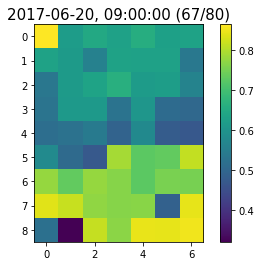

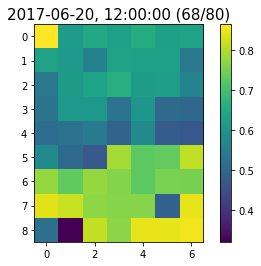

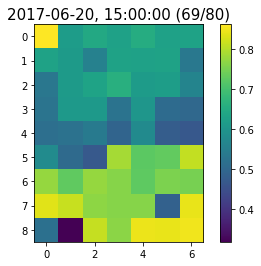

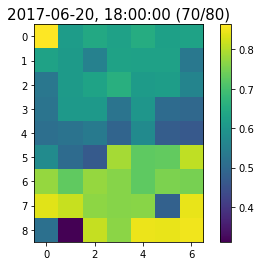

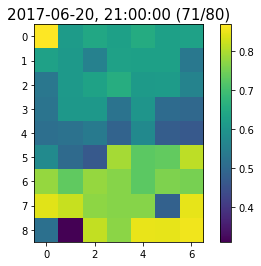

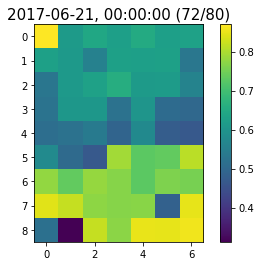

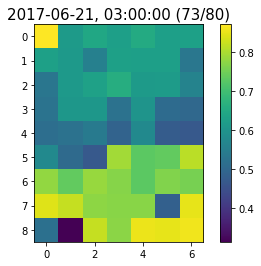

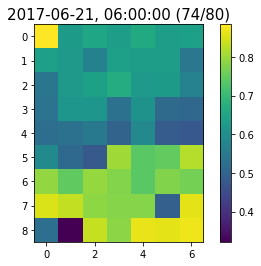

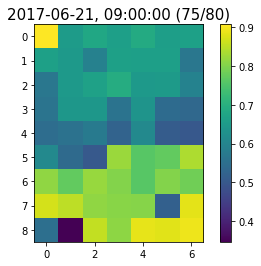

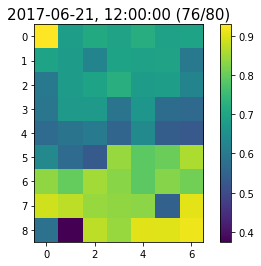

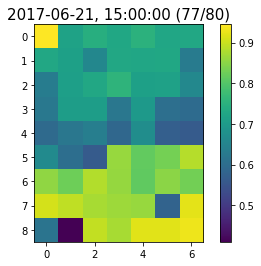

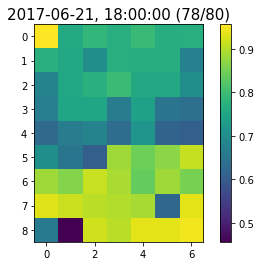

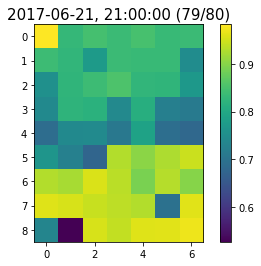

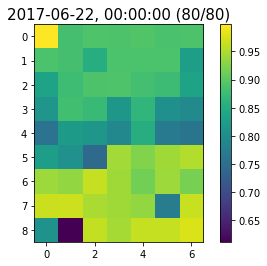

In [8]:
#this block of code is used to get forecasts off of a forcing grid (could be used for output grid as well)
#netcdf_path = os.path.join(".","nwm.20170604", "forcing_analysis_assim", "nwm.tALLz.analysis_assim.forcing.tm00.conus.nc")
#netcdf_path = os.path.join(".","nwm.20170604", "short_range", "nwm.t00z.short_range.land.fALL.conus.nc")
netcdf_path = os.path.join(".","nwm.20170604", "medium_range", "nwm.t00z.medium_range.land.fALL.conus.nc")

print (list_hydrologic_variables(netcdf_path))

#date_list,  value_list = get_variable_values(netcdf_path, "PSFC", None)
date_list,  value_list = get_variable_values(netcdf_path, "SOILSAT_TOP", None)
array_2d = value_list[0]

# The origin point of the array retrieved from netcdf file is in upper-left corner (North pointing downward)
# We need to make North face upward before plotting it in matplotlib.pyplot
# Flip array in the up/down direction
# see: https://docs.scipy.org/doc/numpy-dev/reference/generated/numpy.flipud.html#numpy.flipud
# [[1, 2],   -->  [[3, 4],
#  [3, 4]]         [1, 2]]

for i in range(len(date_list)):
    timestamp = date_list[i]
# Plot each timestamp
    array_2d = value_list[i]
# The origin point of the array retrieved from netcdf file is in upper-left corner (North pointing downward)
# We need to make North face upward before plotting it in matplotlib.pyplot
# Flip array in the up/down direction
# see: https://docs.scipy.org/doc/numpy-dev/reference/generated/numpy.flipud.html#numpy.flipud
# [[1, 2],   -->  [[3, 4],
#  [3, 4]]         [1, 2]]
    array_2d_flipped = numpy.flipud(array_2d)
# plt.subplot(row_num, col_num, i+1)
    title = timestamp.strftime("%Y-%m-%d, %H:%M:%S") + " ({0}/{1})".format(i+1, len(date_list))
    plt.title(title, fontsize=15)
    plt.imshow(array_2d_flipped, interpolation="none")
    plt.colorbar()
    plt.show()




#array_2d_flipped = numpy.flipud(array_2d)
#plt.imshow(array_2d_flipped, interpolation="none")
#plt.colorbar()
    
#plt.show()